# Red Giant Mode fitting

Start with 1 RG star chosen at random.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

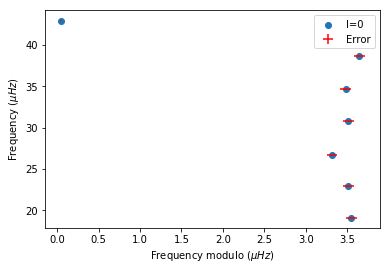

In [109]:
ID = 7741179 # Use ID to choose star
# import data
output = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, index_col=0)  #import output data
modes = pd.read_csv('RGdata/modes_'+str(ID)+'.csv', delim_whitespace=False, header=0)
# Find parameters numax, dnu and errors
numax_obs = float(output.loc[output.ID == ID].Numax)
numax_obs_err = float(output.loc[output.ID == ID].Numax_err)
dnu_obs = float(output.loc[output.ID == ID].Dnu_median)
dnu_obs_err = float(output.loc[output.ID == ID].Dnu_median_err)
# Create dataframes for frequencies and calculate orders n
l0modes = pd.DataFrame([modes.f0, modes.f0_err])
l0modes = l0modes.T
l0modes = l0modes.sort_values('f0', ascending=True)
n_min = int(l0modes.f0.min() / dnu_obs)
n_obs = np.arange(n_min, n_min+len(l0modes.f0), 1)
l0modes['n'] = n_obs
l0modes = l0modes.set_index(np.arange(0, len(l0modes.f0), 1))

plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'l=0')  
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()
#plt.xlim(3.0, dnu_obs)

To find a ballpark figure before defining priors, will use model:

$$\nu(n)=(n+\epsilon)\langle\Delta\nu\rangle+k(n_{max}-n)^2+\mathcal{A}e^{-n/\tau}sin(nw+\phi)$$

where $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [110]:
def model(n, dnu, nmax, epsilon, k, A, w, tau, phi):
    freqs = (n + epsilon) * dnu + k * (nmax - n)**2 + A * np.exp(-n/tau) * np.sin(n * w + phi);
    return freqs

In [140]:
n = l0modes.n
epsilon = 1.74
nmax = numax_obs/dnu_obs - epsilon
k = 0.09
A = 1.8
w = 3
tau = 4
phi = 0
f = model(n, dnu_obs, nmax, epsilon, k, A, w, tau, phi)

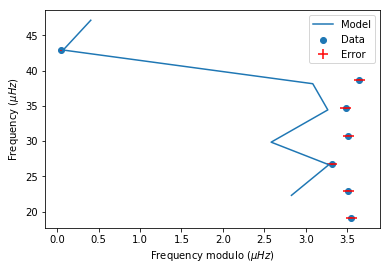

In [141]:
plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()

In [142]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {   
    real dnu;
    real epsilon;
    real<lower = 0> nmax;
    real k;
    real<lower = 0> A;
    real<lower = 0> w;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon) * dnu + k * (nmax - n[i])^2 + 
            A * exp(-n[i]/tau) * sin(n[i] * w + phi);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(1.75, 0.60);
    epsilon ~ uniform(0.50, 2.50);
    nmax ~ normal(6, 2);
    k ~ lognormal(log(0.1), 0.2);
    A ~ lognormal(log(1.5), 0.7);
    w ~ normal(2.3, 0.7);
    tau ~ normal(3, 1);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44f17e51372083433f7aaa471eb32626 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpa64cnkx9/stanfit4anon_model_44f17e51372083433f7aaa471eb32626_3579478348552231860.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [151]:
data = {'N': len(l0modes.f0), 'freq': l0modes.f0, 'freq_err': l0modes.f0_err, 
        'dnu_guess': dnu_obs, 'n': l0modes.n}
start = {'dnu': 2.00, 'epsilon': 0.8, 'nmax': nmax, 'k': 0.05, 'A': 0.3, 'w': 0.3, 'phi': -1.8*np.pi, 'tau': 1}
nchains=4
fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

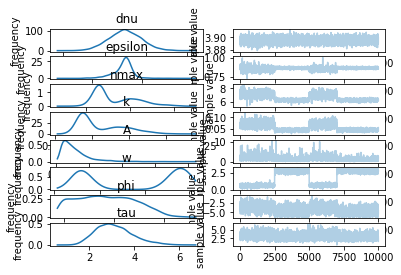

In [152]:
fit.plot()
plt.show()

In [153]:
print(fit)

Inference for Stan model: anon_model_44f17e51372083433f7aaa471eb32626.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.89  5.8e-5 3.9e-3   3.89   3.89   3.89    3.9    3.9   4575    1.0
epsilon   0.86  3.0e-3   0.02   0.81   0.85   0.87   0.87   0.89     46   1.07
nmax      6.65    0.27   0.49   6.04   6.28   6.43   7.03   7.77      3   1.72
k         0.06  8.9e-3   0.02   0.04   0.04   0.05   0.07   0.09      3   1.73
A         1.44     0.3   1.05   0.35   0.72   1.16   1.82   4.23     12   1.13
w         1.78    0.69   1.08   0.36   0.61   2.48   2.78   3.04      2   2.81
phi      -4.33     0.5   1.15  -6.16  -5.28  -4.38  -3.44  -2.17      5    1.3
tau       3.13    0.15   0.81   1.78   2.53   3.04   3.62   4.98     29   1.06
lp__    -13.03    1.66   3.32  -19.9 -15.28 -12.98 -10.19  -7.87      4   1.46

Samples were drawn 

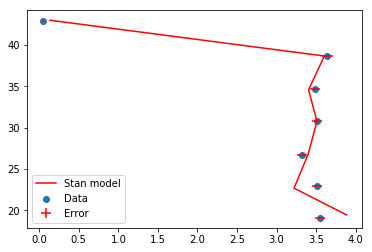

In [154]:
stanfit = model(l0modes.n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(), fit['A'].mean(), fit['w'].mean(), fit['tau'].mean(), fit['phi'].mean())

plt.subplots()
plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data')
plt.plot(stanfit % fit['dnu'].mean(), stanfit, label = 'Stan model', color = 'r')
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()

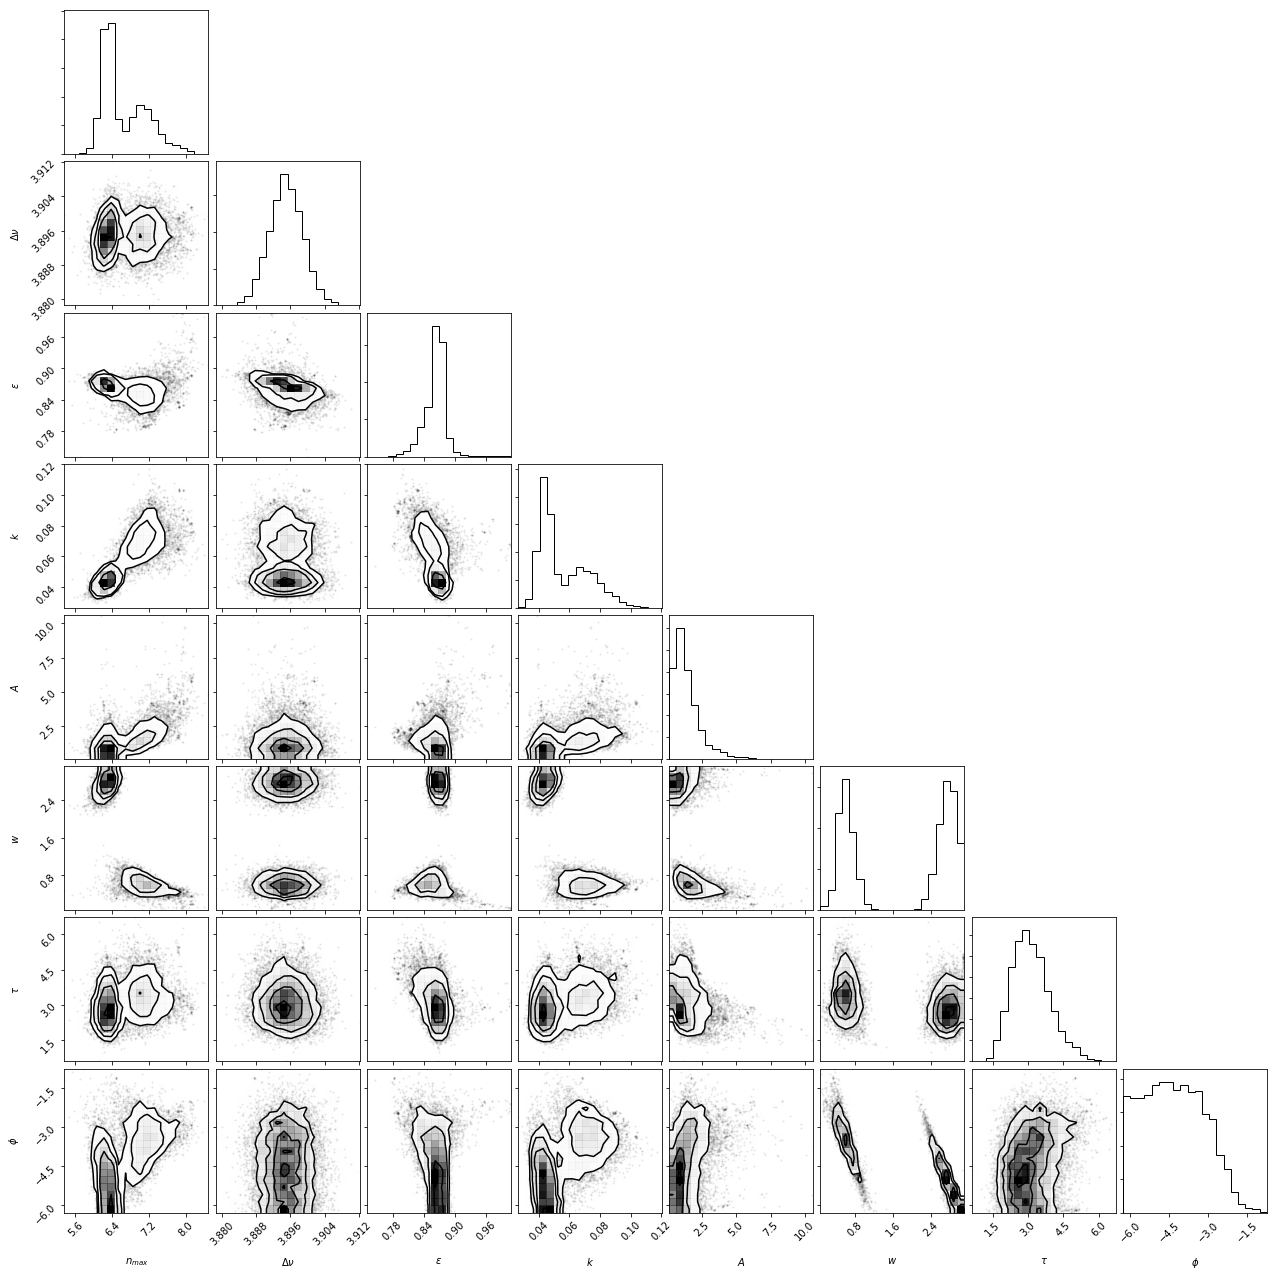

In [155]:
import corner
data = np.vstack([fit['nmax'], fit['dnu'], fit['epsilon'], fit['k'], fit['A'], fit['w'], fit['tau'], fit['phi'],]).T
corner.corner(data, labels=[r'$n_{max}$', r'$\Delta\nu$', r'$\epsilon$', r'$k$', r'$A$', r'$w$', r'$\tau$', r'$\phi$'])
plt.show()